In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "cs231n/project/"
assert FOLDERNAME is not None, "[!] Enter the foldername."
PROJECT_PATH = f"/content/drive/My Drive/{FOLDERNAME}"
sys.path.append(PROJECT_PATH)

# Change working directory
os.chdir(PROJECT_PATH)

# Confirm
print("✅ Current working directory:", os.getcwd())
print("📁 Contents:", os.listdir('.'))

Mounted at /content/drive
✅ Current working directory: /content/drive/My Drive/cs231n/project
📁 Contents: ['.ipynb_checkpoints', '__pycache__', 'data', 'lora.py', 'dataset.py', 'augment.py', 'wandb', 'patch_unet.py', 'lora_weights.pth', 'data_curation', 'lora_sd_colab.ipynb', 'generated_images']


# 💡 LoRA Training on Stable Diffusion
This notebook trains custom LoRA adapters on Stable Diffusion using your own image-caption pairs.


In [2]:
!pip install -q diffusers transformers accelerate torchvision safetensors kornia wandb

## Data Preparation

In [3]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from dataset import ImageTextDataset

dataset = ImageTextDataset("data")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# sanity check for datasets
print(f"Number of image-caption pairs: {len(dataset)}")

Number of image-caption pairs: 251


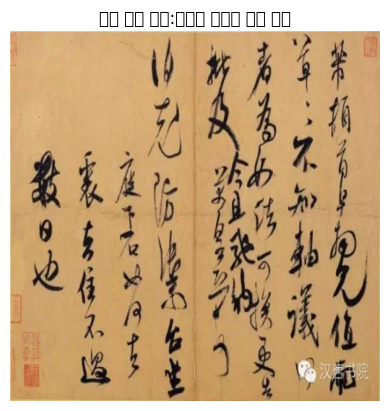

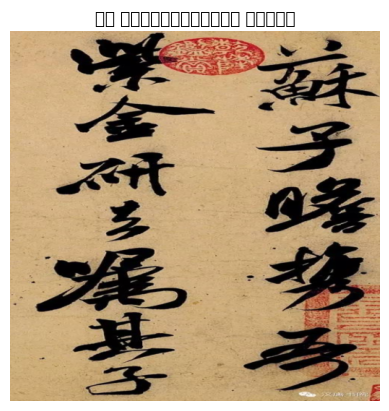

In [4]:
# preview a couple of images.
from matplotlib import pyplot as plt
import warnings
import re

# This regex will match messages containing "Glyph" and "missing from font"
warnings.filterwarnings("ignore", category=UserWarning, message=r"Glyph .* missing from font\(s\) DejaVu Sans\.")

for i in range(min(2, len(dataset))):  # Show up to 3 examples
    image, caption = dataset[i]
    plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Undo normalization
    plt.axis("off")
    plt.title(caption)
    plt.show()


## Training Logic for Lora Finetuning

In [5]:
import wandb

import os
os.environ["WANDB_API_KEY"] = "20e7c4be307028d246fbff111508b75d9eaab1ee"
wandb.login()

wandb.init(
    project="stable-diffusion-calligraphy",
    name="米芾_褚遂良_10epoch",  # give each experiment a unique name
    config={
        "lora_rank": 4,
        "lora_alpha": 1.0,
        "lr": 1e-4,
        "epochs": 1,
        "augmentations": True,
        "conv_lora": True,
    }
)

wandb: Currently logged in as: baibaipangpang-bbpp (baibaipangpang-bbpp-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
from lora import LoRALinear, LoRAConv2d
from patch_unet import patch_unet_with_lora, conv_filter

device = "cuda"
from diffusers import StableDiffusionPipeline
import torch.nn as nn


pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32).to(device)

pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.unet.requires_grad_(False)

# ADD LORA
# patch_unet_with_lora(pipe.unet, r=4, alpha=1.0, dropout=0.0)
patch_unet_with_lora(pipe.unet, r=4, alpha=1.0, dropout=0.0, conv_filter=None)

pipe.unet.to(device)  # Move after patching

# unfreeze lora weights
for module in pipe.unet.modules():
    if isinstance(module, (LoRALinear, LoRAConv2d)):
        for p in module.parameters():
            p.requires_grad = True

optimizer = torch.optim.Adam([p for p in pipe.unet.parameters() if p.requires_grad], lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
# patch_unet_with_lora(
#     pipe.unet,
#     r=4,
#     alpha=1.0,
#     dropout=0.1,
#     enable_linear=False,
#     enable_conv=True,
#     conv_filter=lambda name, mod: "down_blocks" in name and mod.kernel_size == (3, 3)
# )

In [ ]:
import torch
from augment import augment
from patch_unet import save_lora_weights, load_lora_weights
import torch.nn as nn

# training
for epoch in range(10):
    for i, (images, captions) in enumerate(loader):
        # Keep images in float32
        images = images.to(device)

        images = augment(images)

        text_input = pipe.tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt").to(device)
        text_embeds = pipe.text_encoder(**text_input).last_hidden_state.to(device)  # stays float32

        with torch.no_grad():
            vae_output = pipe.vae.encode(images)
        latents = vae_output.latent_dist.sample().to(device) * 0.18215  # float32

        noise = torch.randn_like(latents).to(device)  # float32 noise
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

        noise_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states=text_embeds).sample  # float32

        loss = nn.MSELoss()(noise_pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Epoch {epoch} Step {i} Loss: {loss.item():.4f}")
        wandb.log({
            "epoch": epoch,
            "step": i,
            "loss": loss.item(),
            "lr": optimizer.param_groups[0]["lr"],
        })

    # Denormalize image and convert to numpy
    sample_image = (images[0].cpu().numpy() * 0.5 + 0.5).transpose(1, 2, 0)
    wandb.log({"input_image": [wandb.Image(sample_image, caption=captions[0])]})


save_lora_weights(pipe.unet, path="lora_weights.pth")

Epoch 0 Step 0 Loss: 0.0043
Epoch 0 Step 1 Loss: 0.0048
Epoch 0 Step 2 Loss: 0.2676
Epoch 0 Step 3 Loss: 0.0777
Epoch 0 Step 4 Loss: 0.2962
Epoch 0 Step 5 Loss: 0.2767
Epoch 0 Step 6 Loss: 0.0234
Epoch 0 Step 7 Loss: 0.1498
Epoch 0 Step 8 Loss: 0.0069
Epoch 0 Step 9 Loss: 0.1169
Epoch 0 Step 10 Loss: 0.2218
Epoch 0 Step 11 Loss: 0.1220
Epoch 0 Step 12 Loss: 0.3906
Epoch 0 Step 13 Loss: 0.1002
Epoch 0 Step 14 Loss: 0.1461
Epoch 0 Step 15 Loss: 0.7993
Epoch 0 Step 16 Loss: 0.1885
Epoch 0 Step 17 Loss: 0.4524
Epoch 0 Step 18 Loss: 0.3392
Epoch 0 Step 19 Loss: 0.0021
Epoch 0 Step 20 Loss: 0.2636
Epoch 0 Step 21 Loss: 0.3460
Epoch 0 Step 22 Loss: 0.2157
Epoch 0 Step 23 Loss: 0.3882
Epoch 0 Step 24 Loss: 0.0040
Epoch 0 Step 25 Loss: 0.4135
Epoch 0 Step 26 Loss: 0.0927
Epoch 0 Step 27 Loss: 0.1417
Epoch 0 Step 28 Loss: 0.0092
Epoch 0 Step 29 Loss: 0.0348
Epoch 0 Step 30 Loss: 0.3111
Epoch 0 Step 31 Loss: 0.4001
Epoch 0 Step 32 Loss: 0.0877
Epoch 0 Step 33 Loss: 0.0933
Epoch 0 Step 34 Loss: 0.

## Generate images with Trained LoRA

In [ ]:
state_dict = torch.load("lora_weights.pth", map_location=device)
patch_unet_with_lora(pipe.unet, r=4, alpha=1.0)
pipe.unet.load_state_dict(state_dict, strict=False)
pipe.unet.eval()

prompt = "米芾 书法 "
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

for i in range(3):
    image = pipe(prompt, num_inference_steps=30).images[0]
    wandb.log({"output image": [wandb.Image(image, caption=captions[0])]})
    image.save(f"{output_dir}/米芾_书法_generated_{i}.png")
    image.show()
    display(image)   # shows inline in the notebook

prompt = "褚遂良 书法 "
for i in range(3):
    image = pipe(prompt, num_inference_steps=30).images[0]
    wandb.log({"output image": [wandb.Image(image, caption=captions[0])]})
    image.save(f"{output_dir}/褚遂良_书法_generated_{i}.png")
    image.show()
    display(image)   # shows inline in the notebook

prompt = "书法 "
for i in range(3):
    image = pipe(prompt, num_inference_steps=30).images[0]
    wandb.log({"output image": [wandb.Image(image, caption=captions[0])]})
    image.save(f"{output_dir}/书法_generated_{i}.png")
    image.show()
    display(image)   # shows inline in the notebook


wandb.finish()